In [1]:
"""
Name: example.ipynb
Authors: Stephan Meighen-Berger, Martina Karl
Example for the package
"""

'\nName: example.ipynb\nAuthors: Stephan Meighen-Berger, Martina Karl\nExample for the package\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config

In [6]:
# Some example settings
config['scenario']['population size'] = 1000
config['geometry']['box size'] = 1e2
config['geometry']['bounding box'] = 1.1e2
config['organisms']['emission fraction'] = 0.5
config['water']['water current velocity'] = 5.

In [7]:
# Creating a fourth_day object
fd = Fourth_Day()

In [8]:
# Launching solver
fd.sim()

(1000, 2)
(1000, 2)
(1010, 2)
(1010, 2)
(1020, 2)
(1020, 2)
(1030, 2)
(1030, 2)
(1040, 2)
(1040, 2)
(1050, 2)
(1050, 2)
(1060, 2)
(1060, 2)
(1070, 2)
(1070, 2)
(1080, 2)
(1080, 2)
(1090, 2)
(1090, 2)
(1100, 2)
(1100, 2)
(1110, 2)
(1110, 2)
(1120, 2)
(1120, 2)
(1130, 2)
(1130, 2)
(1140, 2)
(1140, 2)
(1150, 2)
(1150, 2)
(1160, 2)
(1160, 2)
(1170, 2)
(1170, 2)
(1180, 2)
(1180, 2)
(1190, 2)
(1190, 2)
(1200, 2)
(1200, 2)
(1210, 2)
(1210, 2)
(1220, 2)
(1220, 2)
(1230, 2)
(1230, 2)
(1240, 2)
(1240, 2)
(1250, 2)
(1250, 2)
(1260, 2)
(1260, 2)
(1270, 2)
(1270, 2)
(1280, 2)
(1280, 2)
(1290, 2)
(1290, 2)
(1300, 2)
(1300, 2)
(1310, 2)
(1310, 2)
(1320, 2)
(1320, 2)
(1330, 2)
(1330, 2)
(1340, 2)
(1340, 2)
(1350, 2)
(1350, 2)
(1360, 2)
(1360, 2)
(1370, 2)
(1370, 2)
(1380, 2)
(1380, 2)
(1390, 2)
(1390, 2)
(1400, 2)
(1400, 2)
(1410, 2)
(1410, 2)
(1420, 2)
(1420, 2)
(1430, 2)
(1430, 2)
(1440, 2)
(1440, 2)
(1450, 2)
(1450, 2)
(1460, 2)
(1460, 2)
(1470, 2)
(1470, 2)
(1480, 2)
(1480, 2)
(1490, 2)
(1490, 2)


In [9]:
fd.statistics[-1]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,regeneration,is_emitting,emission_duration,encounter photons,shear photons,photons
0,Ctenophores Haeckelia rubra (KoÃˆlliker),49.049356,23.204515,0.003272,1.910897,0.001133,1.0,False,9.289265,0.5,0.001,False,-8.0,0.0,0.0,0.0
1,Cnidaria_Hydrozoa Halicreidae unidentified spe...,49.159482,33.254583,0.002103,0.426799,0.000612,1.0,False,13.838410,0.5,0.001,False,-2.0,0.0,0.0,0.0
2,Cnidaria_Hydrozoa_Hydroidolina_Siphonophores_P...,46.585698,2.129511,0.003208,1.285668,0.000615,1.0,False,12.155737,0.5,0.001,False,-16.0,0.0,0.0,0.0
3,Ctenophores Thalassocalyce inconstans Madin an...,46.854442,48.358828,0.002212,1.623907,0.000844,1.0,False,7.177329,0.5,0.001,False,-13.0,0.0,0.0,0.0
4,Cnidaria_Hydrozoa_Hydroidolina_Siphonophores_P...,45.957325,2.079573,0.006131,2.510067,0.001345,1.0,False,10.993161,0.5,0.001,False,-6.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,Ctenophores Ocyropsis maculata immaculata Harb...,-50.000000,-15.204856,0.000000,0.000000,0.000919,1.0,True,18.059535,0.5,0.001,False,0.0,0.0,0.0,0.0
1496,Cnidaria_Hydrozoa Solmissus marshalli Agassiz ...,-50.000000,44.979155,0.000000,0.000000,0.001480,1.0,True,6.553237,0.5,0.001,False,0.0,0.0,0.0,0.0
1497,Cnidaria_Hydrozoa_Hydroidolina_Siphonophores_P...,-50.000000,2.547321,0.000000,0.000000,0.001403,1.0,True,8.285787,0.5,0.001,False,0.0,0.0,0.0,0.0
1498,Cnidaria_Scyphomedusae Nausithoe globifera Broch,-50.000000,-36.000546,0.000000,0.000000,0.000834,1.0,True,10.515729,0.5,0.001,False,0.0,0.0,0.0,0.0


In [10]:
# Plotting standards
std_size = 10.
fontsize = 20.
lw=3.
h_length=1.5

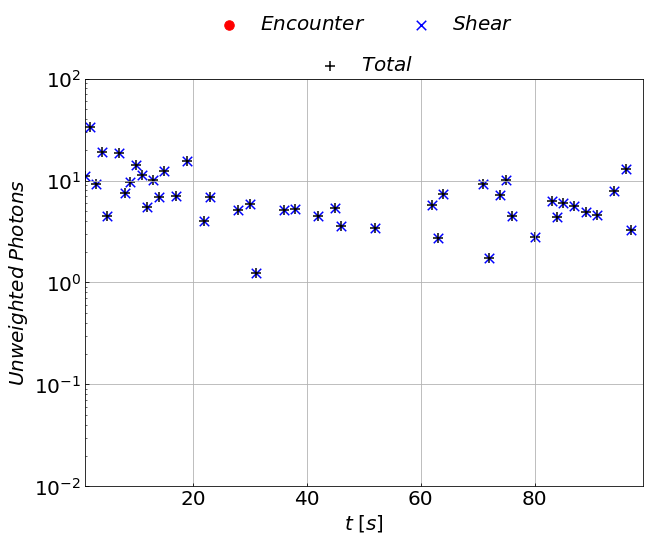

In [11]:
# Energy distributions
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
data_enc = np.array([np.sum(fd.statistics[i].loc[:, 'encounter photons'].values)
                     for i in range(len(fd.t))])
data_shear = np.array([np.sum(fd.statistics[i].loc[:, 'shear photons'].values)
                       for i in range(len(fd.t))])
data = np.array([np.sum(fd.statistics[i].loc[:, 'photons'].values)
                     for i in range(len(fd.t))])
ax1.scatter(fd.t,
            data_enc,
            s=lw*30, color='r', label=r'$Encounter$', marker="o")
ax1.scatter(fd.t,
            data_shear,
            s=lw*30, color='b', label=r'$Shear$', marker="x")
ax1.scatter(fd.t,
            data,
            s=lw*30, color='k', label=r'$Total$', marker="+")
ax1.set_xlim(1e0, max(fd.t))
ax1.set_ylim(1e-2, 1e2)
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$t\;[s]$', fontsize=fontsize)
ax1.set_ylabel(r'$Unweighted\;Photons$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h[:2],l[:2], loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
lgd2 = ax1.legend(h[2:],l[2:], loc=9, bbox_to_anchor=(0.5, +1.1),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.add_artist(lgd1)
plt.show()

In [12]:
figure.savefig(PICS + "MC_Example.png",
               bbox_inches='tight')